In [301]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC, SVC
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
import json

with open('train_matches.jsonl') as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

In [3]:
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

В данных из jsonl файлов есть много признаков, которых нет в датасете, добавим часть этих признаков

In [4]:
def add_new_features(df_features, matches_file):
    '''Функция добавляет новые признаки в данные из jsonl файлов'''
    items = {}
    for index, match in enumerate(read_matches(matches_file)):
        match_id_hash = match['match_id_hash']

        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1
        for j in range(10):
            rapiers = 0
            bkb = 0
            for item in match['players'][j]['hero_inventory']:
                if item['id'] == 'item_rapier':
                    rapiers += 1       
                if item['id'] == 'item_black_king_bar':
                    bkb = 1
            max_streak = 0
            sum_streaks = 0
            damage = 0
            for key in match['players'][j]['kill_streaks'].keys():
                sum_streaks += match['players'][j]['kill_streaks'][key]
                if match['players'][j]['kill_streaks'][key] > max_streak:
                    max_streak = match['players'][j]['kill_streaks'][key]

            for key in match['players'][j]['damage_inflictor'].keys():
                damage += match['players'][j]['damage_inflictor'][key]
            if j < 5:
                df_features.loc[match_id_hash, f'r{j + 1}_ability_uses'] = len(match['players'][j]['ability_uses'])
                df_features.loc[match_id_hash, f'r{j + 1}_item_uses'] = len(match['players'][j]['item_uses'])
                df_features.loc[match_id_hash, f'r{j + 1}_purchase_log'] = len(match['players'][j]['purchase_log'])
                df_features.loc[match_id_hash, f'r{j + 1}_max_hero_hit'] = match['players'][j]['max_hero_hit']['value']
                df_features.loc[match_id_hash, f'r{j + 1}_sum_of_streaks'] = sum_streaks
                df_features.loc[match_id_hash, f'r{j + 1}_damage'] = damage
                df_features.loc[match_id_hash, f'r{j + 1}_max_streak'] = max_streak
                df_features.loc[match_id_hash, f'r{j + 1}_bkb'] = bkb
                df_features.loc[match_id_hash, f'r{j + 1}_rapier'] = rapiers
            else:
                df_features.loc[match_id_hash, f'd{j - 4}_ability_uses'] = len(match['players'][j]['ability_uses'])
                df_features.loc[match_id_hash, f'd{j - 4}_item_uses'] = len(match['players'][j]['item_uses'])
                df_features.loc[match_id_hash, f'd{j - 4}_purchase_log'] = len(match['players'][j]['purchase_log'])
                df_features.loc[match_id_hash, f'd{j - 4}_max_hero_hit'] = match['players'][j]['max_hero_hit']['value']
                df_features.loc[match_id_hash, f'd{j - 4}_sum_of_streaks'] = sum_streaks
                df_features.loc[match_id_hash, f'd{j - 4}_damage'] = damage
                df_features.loc[match_id_hash, f'd{j - 4}_max_streak'] = max_streak
                df_features.loc[match_id_hash, f'd{j - 4}_bkb'] = bkb
                df_features.loc[match_id_hash, f'd{j - 4}_rapier'] = rapiers
    
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
        for j in range(1, 6):
            df_features.loc[match_id_hash, f'r{j}_randomed'] = match['players'][j - 1]['randomed']
            df_features.loc[match_id_hash, f'd{j}_randomed'] = match['players'][j + 4]['randomed']

Считаем данные и добавим новые признаки

In [ ]:
train_features = pd.read_csv('train_features.csv', index_col='match_id_hash')
train_targets = pd.read_csv('train_targets.csv', index_col='match_id_hash')
add_new_features(train_features, 'train_matches.jsonl')

test_features = pd.read_csv('test_features.csv', index_col='match_id_hash')
add_new_features(test_features, 'test_matches.jsonl')

Заметим, что в данных каждый игрок представлен своими отдельными признаками, при этом учитывается их порядок. Попробуем это исправить, ведь для команды не так важен порядок игроков, а важна сила всей команды. Для этого попробуем из статистик игроков агрегировать статистики, которые бы описывали силу всей команды, это должно помочь в обучении.

In [ ]:
players_columns = ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health',
       'max_health', 'max_mana', 'level', 'stuns', 'creeps_stacked', 'camps_stacked',
       'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed',
       'roshans_killed', 'obs_placed', 'sen_placed', 'randomed', 'ability_uses',
       'item_uses', 'purchase_log', 'max_hero_hit','sum_of_streaks', 'max_streak', 'bkb', 'rapier', 'damage']

Не будем пользоваться координатами игроков, выкинем эти признаки

In [ ]:
drop = ['r1_x', 'r1_y', 'r2_x', 'r2_y', 'r3_x', 'r3_y', 'r4_x', 'r4_y', 'r5_x', 'r5_y',
       'd1_x', 'd1_y', 'd2_x', 'd2_y', 'd3_x', 'd3_y', 'd4_x', 'd4_y', 'd5_x', 'd5_y']
train_features.drop(columns=drop, inplace=True)
test_features.drop(columns=drop, inplace=True)

Сформируем признаки команды по признаками игроков(players columns), будем брать max/min/std/mean из признаков игроков. Там где брать mean или std нельзя(например, в бинарных признаках bkb и rapiers) будем брать просто сумму

In [ ]:
def team_features(features):
    rd = ['r', 'd']
    for column in players_columns:
        for team in rd:
            names = [team + str(j) + '_' + column for j in range(1, 6)]
            players_stat = features[names]
            if (column == 'randomed' or column == 'bkb' or column == 'rapier'):
                features[team + '_' + column+ '_sum'] = players_stat.sum(axis=1)
            else:
                features[team + '_' + column + '_mean'] = players_stat.mean(axis=1)
                features[team + '_' + column + '_max'] = players_stat.max(axis=1)
                features[team + '_' + column + '_min'] = players_stat.min(axis=1)
                features[team + '_' + column + '_std'] = players_stat.std(axis=1)            

Из признаков отдельных игроков остались лишь признаки героя, чтобы создать командый признак сделаем простые one-hot вектора каждой команды

In [ ]:
def make_heros_one_hot(data_features):
    r_heros_cols = ['r_hero' + str(j) for j in range(120)]
    d_heros_cols = ['d_hero' + str(j) for j in range(120)]
    r_heros_cols.extend(d_heros_cols)
    heros_df = pd.DataFrame(columns=r_heros_cols)

    for index in tqdm(data_features.index):
        heros_radiant = [0] * 120
        heros_dire = [0] * 120
        features = data_features.loc[index]
        for j in range(1, 6):
            heros_radiant[int(features[f'r{j}_hero_id']) - 1] = 1
            heros_dire[int(features[f'd{j}_hero_id']) - 1] = 1
        heros_radiant.extend(heros_dire)
        heros_df.loc[index] = heros_radiant
    return pd.concat([data_features, heros_df], axis=1)

Добавляем новые признаки

In [ ]:
team_features(train_features)
team_features(test_features)

train_features = make_heros_one_hot(train_features)
test_features = make_heros_one_hot(test_features)

Признаки индексов героев больше не нужны, удалим их

In [ ]:
drop_hero_id = []
for col in train_features.columns:
    if 'hero_id' in col:
        drop_hero_id.append(col)
        
train_features.drop(columns=drop_hero_id, inplace=True)
test_features.drop(columns=drop_hero_id, inplace=True)

Удалим также все остальные признаки конкретного игрока

In [ ]:
rd = ['r', 'd']
drop_columns = []
for j in range(1, 6):
    for team in rd:
        for column in players_columns:
            drop_columns.append(team + str(j) + '_' + column)

train_features.drop(columns=drop_columns, inplace=True)
test_features.drop(columns=drop_columns, inplace=True)

In [ ]:
train_features.to_csv('dota_train.csv')
test_features.to_csv('dota_test.csv')

Посмотрим на новые данные

In [232]:
train_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,radiant_tower_kills,dire_tower_kills,diff_tower_kills,r_kills_mean,r_kills_max,...,d_hero110,d_hero111,d_hero112,d_hero113,d_hero114,d_hero115,d_hero116,d_hero117,d_hero118,d_hero119
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,2.0,0.0,2.0,3.2,7,...,0,0,0,0,0,0,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0.0,0.0,0.0,1.2,3,...,0,0,0,0,0,0,0,0,0,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0.0,0.0,0.0,0.4,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3.0,4.0,-1.0,3.8,8,...,0,0,0,0,0,0,0,0,0,0
bc7a87ed5f9c2bca55f9f7a93da0b0c5,377,22,7,1,0,0.0,0.0,0.0,0.4,1,...,0,0,0,0,0,0,0,0,0,0
e2ca68ac1a6847f4a37f6c9c8ee8695b,643,22,7,1,23,0.0,0.0,0.0,0.8,3,...,0,0,0,0,0,0,0,0,0,1
47ad6454ede66c1c78fdaa9391dfc556,2405,22,7,12,4,6.0,3.0,3.0,8.4,21,...,0,0,0,0,0,0,0,0,0,0


Обучим на этих данные модели, попробуем LogisticRegression, CatBoost и RandomForest

In [90]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_targets['radiant_win'].values, test_size=0.25)

In [38]:
lr = LogisticRegression(n_jobs=8)

lr.fit(X_train, y_train)

preds_lr = lr.predict_proba(X_test)
preds_lr = preds_lr[:,1]
print(roc_auc_score(y_test, preds_lr))

0.8141975936301332


In [ ]:
cb = CatBoostClassifier(iterations=1000)
cb.fit(X_train, y_train)

In [40]:
preds_cb = cb.predict_proba(X_test)
preds_cb = preds_cb[:,1]
print(roc_auc_score(y_test, preds_cb))

0.834414504005955


In [233]:
rf = RandomForestClassifier(random_state=777)

rf.fit(X_train, y_train)

preds_rf = rf.predict_proba(X_test)
preds_rf = preds_rf[:,1]
print(roc_auc_score(y_test, preds_rf))

0.8032463781611461


Лучше всего себя показал CatBoost, попробуем подобрать для него параметры

In [ ]:
model_cb = CatBoostClassifier(eval_metric='AUC', l2_leaf_reg = 7)
parameters = {
    'depth' : [3, 4],
    'learning_rate' : [0.01, 0.05, 0.1],
}
grid_search_results = model_cb.grid_search(parameters, X = train_features, y = train_targets['radiant_win'],)

#model_cb.fit(train_features, train_targets['radiant_win'], early_stopping_rounds=50, plot=True, silent=False)

In [231]:
grid_search_results['params']

{'depth': 4, 'learning_rate': 0.1}

Попробуем подобрать параметры и для других моделей

In [101]:
from sklearn.model_selection import cross_val_score

model_rf = RandomForestClassifier(random_state=777)

param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv = 5)
CV_rfc.fit(train_features, train_targets['radiant_win'])

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=777),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]})

In [122]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [120]:
CV_rfc.cv_results_

{'mean_fit_time': array([ 4.33470454,  8.55604486, 20.97435565,  4.28009353,  8.50891538,
        20.94584093,  2.1274529 ,  3.90976834, 10.22414446,  5.46500406,
        10.71716123, 26.24996333,  5.35629163, 10.68690534, 26.28255582,
         2.4375968 ,  4.75791178, 11.47432055,  6.66513805, 12.98980045,
        31.90734286,  6.48110161, 12.93543925, 31.84109678,  2.92847152,
         5.59928398, 13.51870022,  7.74777975, 15.47330098, 37.76638632,
         7.65738211, 15.38177633, 37.8213069 ,  3.38150468,  6.49364486,
        15.84686146,  8.72576914, 17.47214441, 43.38408298,  8.80269547,
        17.42546926, 43.46954412,  3.88218541,  7.47310076, 18.17649412,
         4.84259706,  9.53456116, 23.31497607,  4.77716775,  9.63247766,
        23.29845066,  2.22704539,  4.25237284, 10.29503117,  6.05847182,
        11.94623141, 29.41637783,  5.98796873, 11.8978622 , 29.78084106,
         2.70540967,  5.18074594, 12.59195595,  7.27876315, 14.545398  ,
        35.74577808,  7.2752604 , 

Cформируем ответы на тестовых данных для CatBoost и RandomForest

In [306]:
preds_cv_cb_test = model_cb.predict_proba(test_features)
preds_cv_cb_test = preds_cv_cb_test[:,1]

submission_cb = pd.DataFrame({'radiant_win_prob': preds_cv_cb_test}, 
                                 index=test_features.index)

submission_cb.to_csv('dota_cv_cb.csv')

In [137]:
preds_cv_rfc_test = CV_rfc.predict_proba(test_features)
preds_cv_rfc_test = preds_cv_rfc_test[:,1]

submission_rfc = pd.DataFrame({'radiant_win_prob': preds_cv_rfc_test}, 
                                 index=test_features.index)

submission_rfc.to_csv('dota_cv_rfc.csv')

Подберем параметры для последней модели

In [164]:
model_lr = LogisticRegression(n_jobs=14,solver='saga')
grid_values = {
    'penalty': ['l1','l2'],
    'C': [0.001,0.01,0.1,1,10,100]}

cv_lr = GridSearchCV(model_lr, param_grid=grid_values, scoring='roc_auc', verbose=10)
cv_lr.fit(train_features, train_targets['radiant_win'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START C=0.001, penalty=l1........................................
[CV 1/5; 1/12] END ......................C=0.001, penalty=l1; total time=  18.9s
[CV 2/5; 1/12] START C=0.001, penalty=l1........................................
[CV 2/5; 1/12] END ......................C=0.001, penalty=l1; total time=  17.7s
[CV 3/5; 1/12] START C=0.001, penalty=l1........................................
[CV 3/5; 1/12] END ......................C=0.001, penalty=l1; total time=  17.6s
[CV 4/5; 1/12] START C=0.001, penalty=l1........................................
[CV 4/5; 1/12] END ......................C=0.001, penalty=l1; total time=  17.5s
[CV 5/5; 1/12] START C=0.001, penalty=l1........................................
[CV 5/5; 1/12] END ......................C=0.001, penalty=l1; total time=  17.6s
[CV 1/5; 2/12] START C=0.001, penalty=l2........................................
[CV 1/5; 2/12] END ......................C=0.001

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(estimator=LogisticRegression(n_jobs=14, solver='saga'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=10)

In [166]:
cv_lr.best_params_

{'C': 0.001, 'penalty': 'l1'}

In [167]:
cv_lr.cv_results_

{'mean_fit_time': array([17.83638501, 13.50257163, 18.39835811, 14.77776532, 19.06052952,
        12.79693894, 20.07850537, 12.83221116, 20.55503278, 12.93836417,
        20.57516804, 12.76168242]),
 'std_fit_time': array([0.51271843, 0.31170222, 0.60503839, 0.3167029 , 0.59077906,
        0.03544063, 0.43044877, 0.12899868, 0.26070795, 0.35160814,
        0.25211022, 0.02569968]),
 'mean_score_time': array([0.03981586, 0.03565793, 0.03513012, 0.03169985, 0.03305788,
        0.03548932, 0.03600893, 0.03711066, 0.04303885, 0.03912058,
        0.04444275, 0.03361659]),
 'std_score_time': array([0.00598942, 0.00242048, 0.00292056, 0.00251554, 0.00239826,
        0.00298945, 0.0078041 , 0.0028472 , 0.004828  , 0.00275275,
        0.01064094, 0.00227352]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10, 100,
                    100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
 

Сформируем ответы и для логистической регрессии

In [171]:
preds_cv_lr_test = cv_lr.predict_proba(test_features)
preds_cv_lr_test = preds_cv_lr_test[:,1]

submission_cv_lr = pd.DataFrame({'radiant_win_prob': preds_cv_lr_test}, 
                                 index=test_features.index)
submission_cv_lr

submission_cv_lr.to_csv('dota_cv_lr.csv')

Как мы видим из результатов простого обучения и кросс-валидации, CatBoost показал себя лучше всех. Попробуем посмотреть на результаты моделей в соревновании(см. в отчете)

Лучшие результаты и логистической регрессии и CatBoost, попробуем взять взвешенное среднее, так как качество у CatBoost лучше, то будем брать его результаты с большим весом

In [192]:
stack_sub = 0.7 * submission_cb + 0.3 * submission_cv_lr

In [193]:
stack_sub

,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.370969
70e5ba30f367cea48793b9003fab9d38,0.974382
4d9ef74d3a2025d79e9423105fd73d41,0.910911
2bb79e0c1eaac1608e5a09c8e0c6a555,0.751488
bec17f099b01d67edc82dfb5ce735a43,0.245337
...,...
9376a283b50779433de829c79529fe2c,0.003567
bce2bace8b61980d282c9f6a9c69ef9c,0.885873
dc00c2964363b0344a4891bdde235a44,0.395474


In [194]:
stack_sub.to_csv('last_try.csv')

Построим матрицу спутываний для CatBoost

[Text(0.5, 1.0, 'Матрица спутываний CatBoost')]

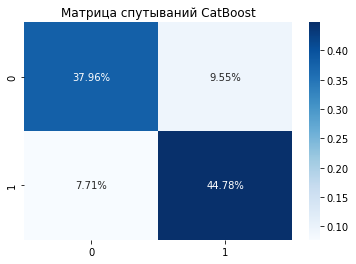

In [237]:
train_preds = model_cb.predict_proba(train_features)
train_preds = train_preds[:,1]
train_preds

cf_matrix = confusion_matrix(train_targets['radiant_win'], train_preds > 0.5)

sns.heatmap(cf_matrix / np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues').set(title='Матрица спутываний CatBoost')

[Text(0.5, 1.0, 'Матрица спутываний RandomForest')]

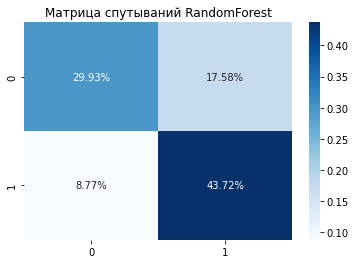

In [239]:
train_preds = CV_rfc.predict_proba(train_features)
train_preds = train_preds[:,1]
train_preds

cf_matrix = confusion_matrix(train_targets['radiant_win'], train_preds > 0.5)

sns.heatmap(cf_matrix / np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues').set(title='Матрица спутываний RandomForest')

Как мы видим, случайный лес часто ошибается в False Positive

[Text(0.5, 1.0, 'Матрица спутываний LogisticRegression')]

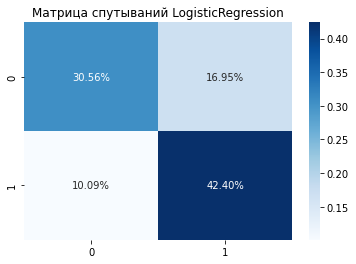

In [241]:
train_preds = cv_lr.predict_proba(train_features)
train_preds = train_preds[:,1]
train_preds

cf_matrix = confusion_matrix(train_targets['radiant_win'], train_preds > 0.5)

sns.heatmap(cf_matrix / np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues').set(title='Матрица спутываний LogisticRegression')

Логистическая регрессия также сильно ошибается в False Positive

Попробуем понизить размерность с помощью PCA, для этого отмасштабируем наши признаки перед применением SVD разложения, при этом дисперсию стандартизировать не будем. Подбирать число компонент будем с помощью кросс-валидации, в качестве модели возьмем CatBoost c лучшими параметрами

In [256]:
model_cb_pca = CatBoostClassifier(iterations=2000, l2_leaf_reg=7, learning_rate=0.1, depth=4)

pipe = Pipeline([('normalize', StandardScaler(with_std=False)),
                 ('pca', PCA()),
                 ('catboost', model_cb_pca)])

cv_pca_cb = GridSearchCV(
    estimator= pipe,
    scoring = 'roc_auc',
    param_grid = {
        'pca__n_components':[200, 250, 300, 350, 400]
    }
)

cv_pca_cb.fit(train_features, train_targets['radiant_win'])

print(cv_pca_cb.best_estimator_.get_params())

0:	learn: 0.6706412	total: 14.4ms	remaining: 28.7s
1:	learn: 0.6523702	total: 25.1ms	remaining: 25.1s
2:	learn: 0.6387565	total: 35.6ms	remaining: 23.7s
3:	learn: 0.6242128	total: 46.1ms	remaining: 23s
4:	learn: 0.6142844	total: 55.8ms	remaining: 22.3s
5:	learn: 0.6054437	total: 65.8ms	remaining: 21.9s
6:	learn: 0.5980993	total: 75.3ms	remaining: 21.4s
7:	learn: 0.5906217	total: 84.7ms	remaining: 21.1s
8:	learn: 0.5844626	total: 93.6ms	remaining: 20.7s
9:	learn: 0.5803784	total: 104ms	remaining: 20.7s
10:	learn: 0.5752315	total: 114ms	remaining: 20.6s
11:	learn: 0.5714654	total: 123ms	remaining: 20.4s
12:	learn: 0.5677001	total: 133ms	remaining: 20.3s
13:	learn: 0.5653789	total: 142ms	remaining: 20.2s
14:	learn: 0.5629933	total: 151ms	remaining: 20s
15:	learn: 0.5601468	total: 161ms	remaining: 20s
16:	learn: 0.5579407	total: 170ms	remaining: 19.9s
17:	learn: 0.5561961	total: 180ms	remaining: 19.9s
18:	learn: 0.5543766	total: 190ms	remaining: 19.9s
19:	learn: 0.5526069	total: 202ms	rema

In [259]:
cv_pca_cb.cv_results_

{'mean_fit_time': array([37.97707067, 31.2310708 , 31.85812902, 33.9976264 , 29.55268908]),
 'std_fit_time': array([8.73971622, 1.48033576, 0.24835779, 0.35124127, 0.06085591]),
 'mean_score_time': array([0.75070405, 0.69911933, 0.77103577, 0.88032212, 0.96507878]),
 'std_score_time': array([0.25809838, 0.12014591, 0.03787484, 0.13436866, 0.07887726]),
 'param_pca__n_components': masked_array(data=[200, 250, 300, 350, 400],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'pca__n_components': 200},
  {'pca__n_components': 250},
  {'pca__n_components': 300},
  {'pca__n_components': 350},
  {'pca__n_components': 400}],
 'split0_test_score': array([0.82328804, 0.82193064, 0.82493343, 0.82878618, 0.82626396]),
 'split1_test_score': array([0.82161998, 0.82544572, 0.82625211, 0.82874032, 0.83048379]),
 'split2_test_score': array([0.82739133, 0.82766384, 0.82887075, 0.83107919, 0.83326585]),
 'split3_test_score': array([0

Как мы видим, результат на кросс-валидации при меньшем числе признаков несильно ухудшается. В целом, catboost итак обучается быстро на наших данных, поэтому необходимости в понижении размерности нет, при этом качество с понижением лишь уменьшается, хоть и незначительно

Проинтерпретируем важность признаков для CatBoost

In [299]:
import shap

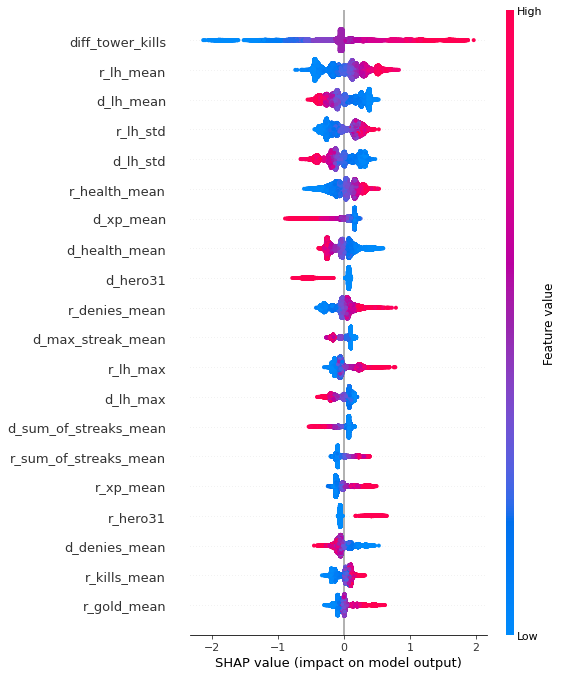

In [305]:
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(train_features)

shap.summary_plot(shap_values, train_features)

Самым важным признаком является разница в количество сломанных вышек, это ожидаемо, потому что цель игры сломать все вышки и трон. Также модель считает, что показатель ласт-хитов крайне важен, это объясняется тем, что от количества ласт-хитов зависит общая ценность игрока, а чем больше золота игрок имеет, тем он сильнее